# Multi-GPU Computation Implementation from Scratch

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, np, npx, gluon
npx.set_np()

!nvidia-smi

Wed Jul  3 05:13:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   43C    P0    54W / 300W |   8388MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Initializing LeNet.

In [2]:
# Initialize model parameters
scale = 0.01
W1 = np.random.normal(scale=scale, size=(20, 1, 3, 3))
b1 = np.zeros(20)
W2 = np.random.normal(scale=scale, size=(50, 20, 5, 5))
b2 = np.zeros(50)
W3 = np.random.normal(scale=scale, size=(800, 128))
b3 = np.zeros(128)
W4 = np.random.normal(scale=scale, size=(128, 10))
b4 = np.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = npx.convolution(data=X, weight=params[0], bias=params[1],
                              kernel=(3, 3), num_filter=20)
    h1_activation = npx.relu(h1_conv)
    h1 = npx.pooling(data=h1_activation, pool_type='avg', kernel=(2, 2),
                    stride=(2, 2))
    h2_conv = npx.convolution(data=h1, weight=params[2], bias=params[3],
                              kernel=(5, 5), num_filter=50)
    h2_activation = npx.relu(h2_conv)
    h2 = npx.pooling(data=h2_activation, pool_type='avg', kernel=(2, 2),
                    stride=(2, 2))
    h2 = h2.reshape((h2.shape[0], -1))
    h3_linear = np.dot(h2, params[4]) + params[5]
    h3 = npx.relu(h3_linear)
    y_hat = np.dot(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

Copy model parameters to a specific GPU and initializes gradients

In [3]:
def get_params(params, ctx):
    new_params = [p.copyto(ctx) for p in params]
    for p in new_params:
        p.attach_grad()
    return new_params

Test

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)
b1 grad: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)


Sum the data on all GPUs and then broadcast it

In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].copyto(data[0].context)
    for i in range(1, len(data)):
        data[0].copyto(data[i])

Test

In [6]:
data = [np.ones((1, 2), ctx=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 [[1. 1.]] @gpu(0) 
 [[2. 2.]] @gpu(1)
after allreduce:
 [[3. 3.]] @gpu(0) 
 [[3. 3.]] @gpu(1)


Split a data batch into multiple GPUs

In [7]:
data = np.arange(24).reshape((6, 4))
ctx = d2l.try_all_gpus()
splitted = gluon.utils.split_and_load(data, ctx)
print('input =\n', data)
print('output =\n', splitted[0], '\n', splitted[1])

input =
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]]
output =
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]] @gpu(0) 
 [[12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]] @gpu(1)


We need to split both the features and labels

In [8]:
def split_batch(X, y, ctx_list):
    """Split X and y into multiple devices specified by ctx"""
    assert X.shape[0] == y.shape[0]
    return (gluon.utils.split_and_load(X, ctx_list),
            gluon.utils.split_and_load(y, ctx_list))

Multi-GPU training on a single mini-batch

In [9]:
def train_batch(X, y, gpu_params, ctx_list, lr):
    gpu_Xs, gpu_ys = split_batch(X, y, ctx_list)
    with autograd.record():  # Loss is calculated separately on each GPU
        ls = [loss(lenet(gpu_X, gpu_W), gpu_y)
              for gpu_X, gpu_y, gpu_W in zip(gpu_Xs, gpu_ys, gpu_params)]
    for l in ls:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Sum all the gradients from each GPU and then broadcast them 
    for i in range(len(gpu_params[0])):
        allreduce([gpu_params[c][i].grad for c in range(len(ctx_list))])
    # The model parameters are updated separately on each GPU
    for param in gpu_params:
        d2l.sgd(param, lr, X.shape[0])  # Here, we use a full-size batch

Training function

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx_list = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    gpu_params = [get_params(params, c) for c in ctx_list]
    num_epochs, times, acces = 10, [], []
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, gpu_params, ctx_list, lr)
            npx.waitall()
        timer.stop()
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, gpu_params[0]), test_iter, ctx[0]),))
    print('test acc: %.2f, %.1f sec/epoch on %s' % (
            animator.Y[0][-1], timer.avg(), ctx_list))


Training with a singe GPU

test acc: 0.80, 1.8 sec/epoch on [gpu(0)]


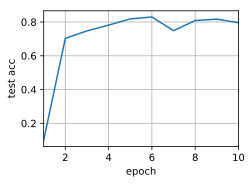

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

Training with two GPUs

test acc: 0.82, 2.5 sec/epoch on [gpu(0), gpu(1)]


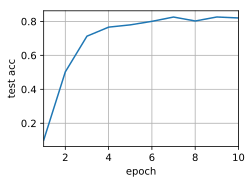

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)